<a href="https://colab.research.google.com/github/rokugatsu/titanic_kaggle/blob/main/Competition01_based_240604_0781.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. ライブラリ・データ読み込み

In [365]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [366]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [367]:
# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
# データの読み込み方がわからない方は、別途配布している、GoogleColabにおけるドライブのマウントの仕方、と、Google Drive上でのフォルダ構造の説明のpdfファイルをご覧ください。
#path = "/content/drive/My Drive/Colab Notebooks/GCI_2024_Summer/Competitions/competition_1/"
path = "/content/drive/MyDrive/data/"

#df = pd.read_csv(path + 'data/train.csv')
#df_test = pd.read_csv(path + 'data/test.csv')

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

df_all = pd.concat([df_train, df_test])

In [368]:
print(df_train.shape)
df_train.head()
df_train

(891, 12)


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,0,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,1,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,0,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#1. データの概観・分析・前処理

In [369]:
print('訓練データのデータ数は{}、変数は{}種類です。'.format(df_train.shape[0], df_train.shape[1]))
print('テストデータのデータ数は{}、変数は{}種類です'.format(df_test.shape[0], df_test.shape[1]))

訓練データのデータ数は891、変数は12種類です。
テストデータのデータ数は418、変数は11種類です


In [370]:
df_train.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [371]:
df_train.isnull().sum()

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [372]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

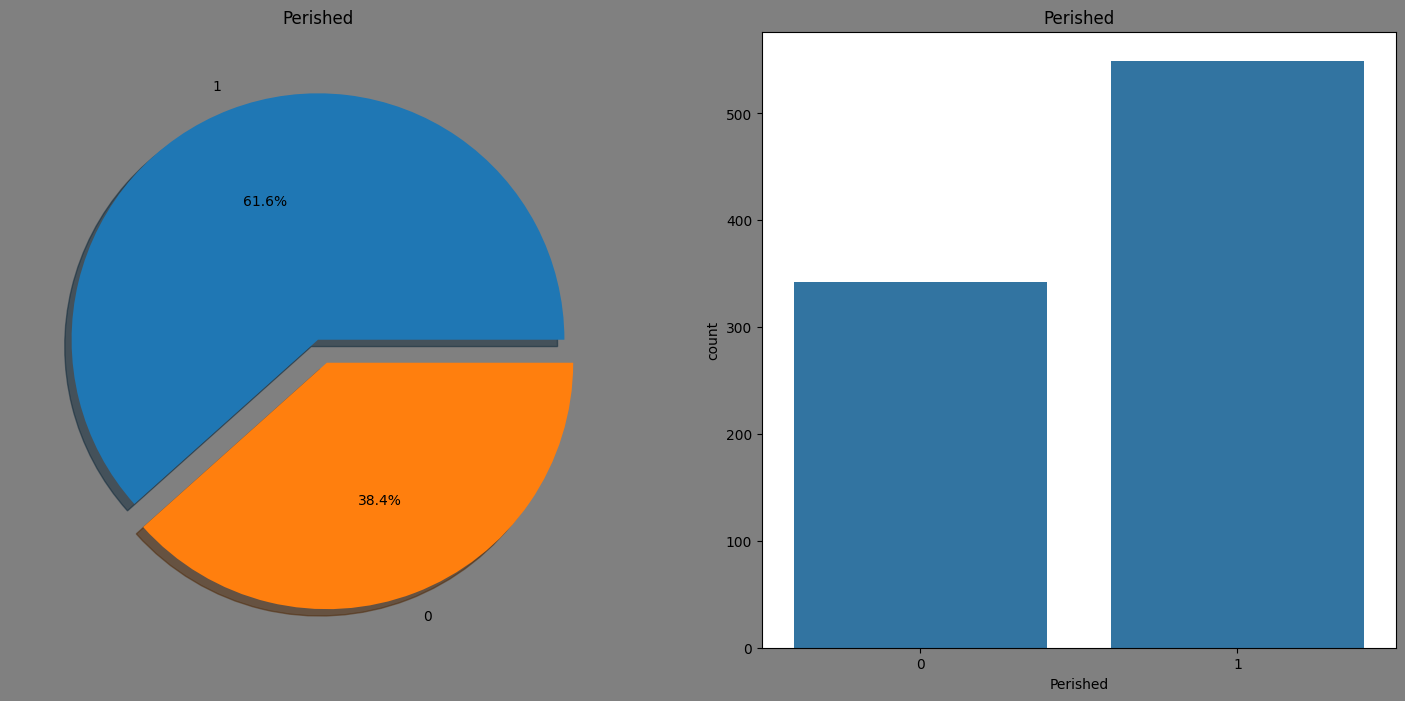

In [373]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df_train['Perished'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Perished')
ax[0].set_ylabel('')
sns.countplot(x='Perished',data=df_train,ax=ax[1])
ax[1].set_title('Perished')
plt.show()

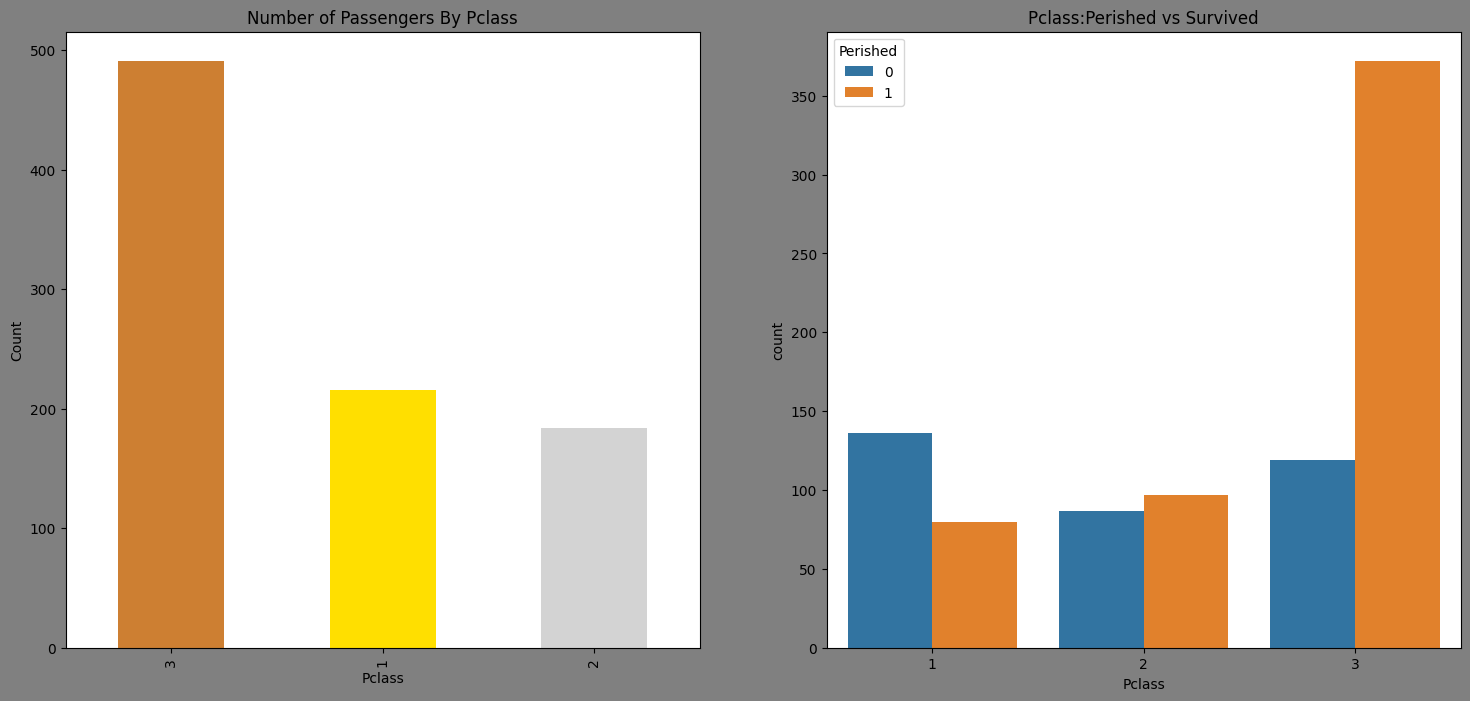

In [374]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass',hue='Perished',data=df_train,ax=ax[1])
ax[1].set_title('Pclass:Perished vs Survived')
plt.show()

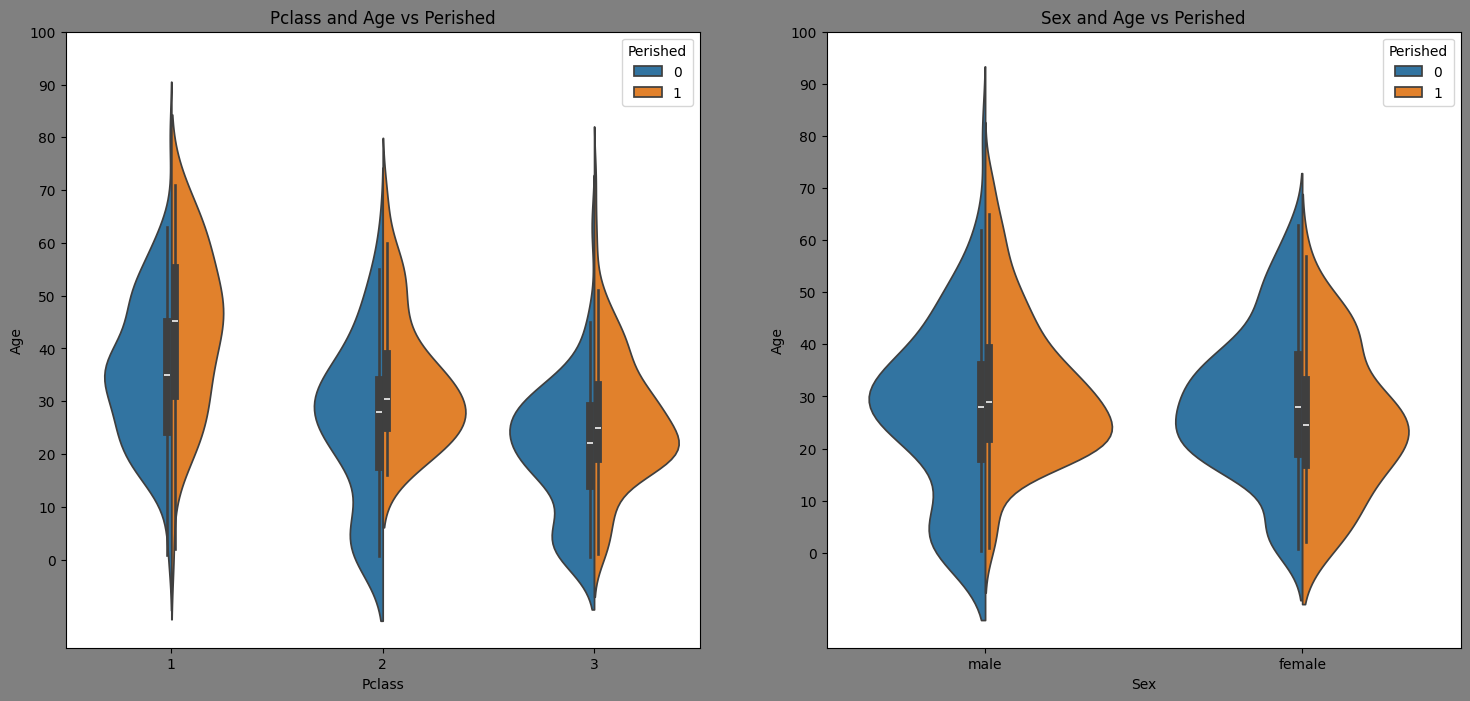

In [375]:
f,ax=plt.subplots(1,2,figsize=(18,8), facecolor='gray')
sns.violinplot(x="Pclass",y="Age", hue="Perished", data=df_train,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Perished')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(x="Sex",y="Age", hue="Perished", data=df_train,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Perished')
ax[1].set_yticks(range(0,110,10))
plt.show()

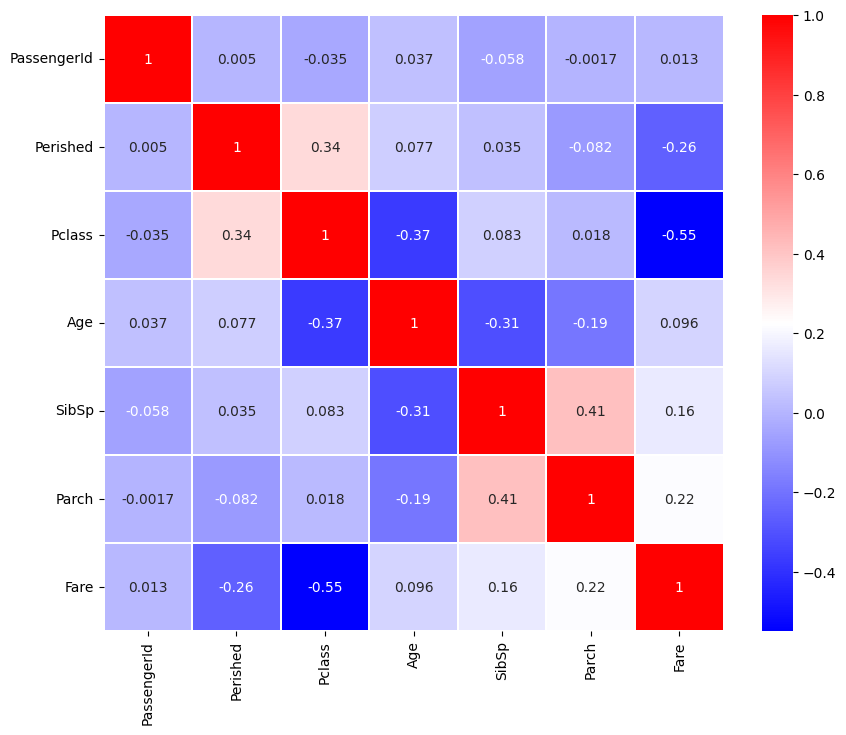

In [376]:
df_numeric = df_train.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [377]:
df_all['FareSingle'] = df_all.Fare/(df_all.SibSp+df_all.Parch+1)
df_all

df_train['FareSingle'] = df_train.Fare/(df_train.SibSp+df_train.Parch+1)
df_test['FareSingle'] = df_test.Fare/(df_test.SibSp+df_test.Parch+1)



,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareSingle
0,1,1.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.625000
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.641650
2,3,0.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,7.925000
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,26.550000
4,5,1.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,8.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,8.050000
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,108.900000
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,7.250000
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,8.050000


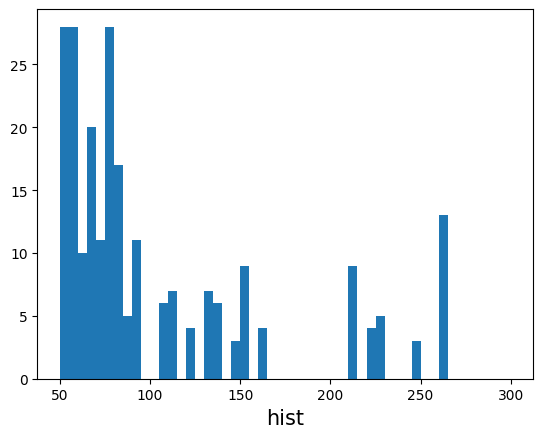

In [378]:
#df_all = pd.concat([df_train, df_test])

# ヒストグラムの描写
# x軸のラベルを指定
plt.xlabel('Fare', fontsize=15)
plt.xlabel('hist', fontsize=15)

#plt.hist(x=df['sepal_length'], bins=25, range=(4.5, 7.5))
plt.hist(x=df_all['Fare'], bins=50, range=(50, 300))

df_train.loc[(df_train['Fare'].values > 200), "Pclass"] = 0
df_test.loc[(df_test['Fare'].values > 200), "Pclass"] = 0
df_all.loc[(df_all['Fare'].values > 200), "Pclass"] = 0

df_all

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareSingle
0,1,1.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.625000
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.641650
2,3,0.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,7.925000
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,26.550000
4,5,1.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,8.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,8.050000
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,108.900000
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,7.250000
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,8.050000


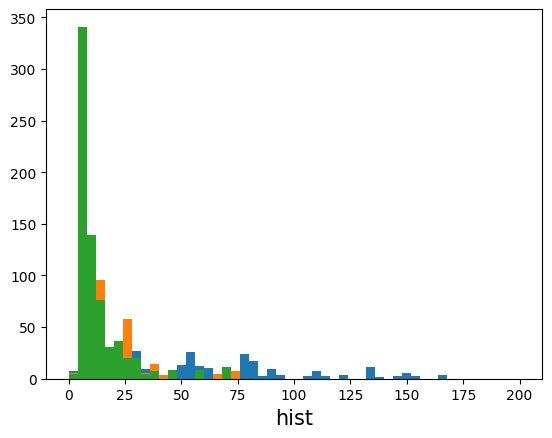

In [379]:
#df_all = pd.concat([df_train, df_test])

# ヒストグラムの描写
# x軸のラベルを指定
plt.xlabel('FareSingle', fontsize=15)
plt.xlabel('hist', fontsize=15)

#plt.hist(x=df['sepal_length'], bins=25, range=(4.5, 7.5))
plt.hist(x=df_all[df_all['Pclass']==1].Fare, bins=50, range=(0, 200))
plt.hist(x=df_all[df_all['Pclass']==2].Fare, bins=50, range=(0, 200))
plt.hist(x=df_all[df_all['Pclass']==3].Fare, bins=50, range=(0, 200))


df_all

Pclass 分類．特１等室=0.5, Fare > 200

In [380]:
#age = pd.concat([df_train['Age'], df_test['Age']])
#fare = pd.concat([df_train['Fare'], df_test['Fare']])

fare = pd.concat([df_train['Fare'], df_test['Fare']])


#df1.groupby('city')['birth_year'].mean()

#df[df['City'] == 'Tokyo']
df_all_Pclass0 = df_all[df_all['Pclass']==0]
df_all_Pclass1 = df_all[df_all['Pclass']==1.0]
df_all_Pclass2 = df_all[df_all['Pclass']==2.0]
df_all_Pclass3 = df_all[df_all['Pclass']==3.0]

Pclass_MasterMale_Mean_Age = df_all[ (df_all['Sex']=='male') & ((df_all.Name.map(lambda x: True if str(x).find('Master.') > 0 else False)))].Age.mean()
Pclass_DrMale_Mean_Age = df_all[ (df_all['Sex']=='male') & ((df_all.Name.map(lambda x: True if str(x).find('Dr.') > 0 else False)))].Age.mean()
Pclass_RevMale_Mean_Age = df_all[ (df_all['Sex']=='male') & ((df_all.Name.map(lambda x: True if str(x).find('Rev.') > 0 else False)))].Age.mean()


#Pclass0
Pclass0_Male_Mean_Age = df_all_Pclass0[df_all_Pclass0['Sex']=='male'].Age.mean()
Pclass0_Male_Mean_Age

#Pclass0_Female_Mean_Age = df_all_Pclass0[df_all_Pclass0['Sex']=='female'].Age.mean()
#Pclass0_Female_Mean_Age

Pclass0_MissFemale_Mean_Age = df_all_Pclass0[ (df_all_Pclass1['Sex']=='female') & (df_all_Pclass0.Name.map(lambda x: True if str(x).find('Miss') > 0 else False))].Age.mean()
Pclass0_MrsFemale_Mean_Age = df_all_Pclass0[ (df_all_Pclass1['Sex']=='female') & (df_all_Pclass0.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False))].Age.mean()

#Pclass1
Pclass1_Male_Mean_Age = df_all_Pclass1[df_all_Pclass1['Sex']=='male'].Age.mean()
Pclass1_Male_Mean_Age

#Pclass1_Female_Mean_Age = df_all_Pclass1[df_all_Pclass1['Sex']=='female'].Age.mean()
#Pclass1_Female_Mean_Age

Pclass1_MissFemale_Mean_Age = df_all_Pclass1[ (df_all_Pclass1['Sex']=='female') & (df_all_Pclass1.Name.map(lambda x: True if str(x).find('Miss') > 0 else False))].Age.mean()
Pclass1_MrsFemale_Mean_Age = df_all_Pclass1[ (df_all_Pclass1['Sex']=='female') & (df_all_Pclass1.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False))].Age.mean()


#Pclass2
Pclass2_Male_Mean_Age = df_all_Pclass2[df_all_Pclass2['Sex']=='male'].Age.mean()
Pclass2_Male_Mean_Age

#Pclass2_Female_Mean_Age = df_all_Pclass2[df_all_Pclass2['Sex']=='female'].Age.mean()
#Pclass2_Female_Mean_Age

Pclass2_MissFemale_Mean_Age = df_all_Pclass2[ (df_all_Pclass2['Sex']=='female') & (df_all_Pclass2.Name.map(lambda x: True if str(x).find('Miss') > 0 else False))].Age.mean()
Pclass2_MrsFemale_Mean_Age = df_all_Pclass2[ (df_all_Pclass2['Sex']=='female') & (df_all_Pclass2.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False))].Age.mean()


#Pclass3
Pclass3_Male_Mean_Age = df_all_Pclass3[df_all_Pclass3['Sex']=='male'].Age.mean()
Pclass3_Male_Mean_Age

#Pclass3_Female_Mean_Age = df_all_Pclass3[df_all_Pclass3['Sex']=='female'].Age.mean()
#Pclass3_Female_Mean_Age

Pclass3_MissFemale_Mean_Age = df_all_Pclass3[ (df_all_Pclass3['Sex']=='female') & (df_all_Pclass3.Name.map(lambda x: True if str(x).find('Miss') > 0 else False))].Age.mean()
Pclass3_MrsFemale_Mean_Age = df_all_Pclass3[ (df_all_Pclass3['Sex']=='female') & (df_all_Pclass3.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False))].Age.mean()

Pclass3_MissFemale_Mean_Age


#print('Pclass0_Male_Mean_Age: {}, Pclass0_Female_Mean_Age: {}'.format(Pclass0_Male_Mean_Age,Pclass0_Female_Mean_Age))
#print('Pclass1_Male_Mean_Age: {}, Pclass1_Female_Mean_Age: {}'.format(Pclass1_Male_Mean_Age,Pclass1_Female_Mean_Age))
#print('Pclass2_Male_Mean_Age: {}, Pclass2_Female_Mean_Age: {}'.format(Pclass2_Male_Mean_Age,Pclass2_Female_Mean_Age))
#print('Pclass3_Male_Mean_Age: {}, Pclass3_Female_Mean_Age: {}'.format(Pclass3_Male_Mean_Age,Pclass3_Female_Mean_Age))


print('Pclass0_Male_Mean_Age: {}, Pclass0_MissFemale_Mean_Age: {}, Pclass0_MsFemale_Mean_Age: {}'.format(Pclass0_Male_Mean_Age,Pclass0_MissFemale_Mean_Age,Pclass0_MrsFemale_Mean_Age))
print('Pclass1_Male_Mean_Age: {}, Pclass1_MissFemale_Mean_Age: {}, Pclass1_MsFemale_Mean_Age: {}'.format(Pclass1_Male_Mean_Age,Pclass1_MissFemale_Mean_Age,Pclass1_MrsFemale_Mean_Age))
print('Pclass2_Male_Mean_Age: {}, Pclass2_MissFemale_Mean_Age: {}, Pclass2_MsFemale_Mean_Age: {}'.format(Pclass2_Male_Mean_Age,Pclass2_MissFemale_Mean_Age,Pclass2_MrsFemale_Mean_Age))
print('Pclass3_Male_Mean_Age: {}, Pclass3_MissFemale_Mean_Age: {}, Pclass3_MsFemale_Mean_Age: {}'.format(Pclass3_Male_Mean_Age,Pclass3_MissFemale_Mean_Age,Pclass3_MrsFemale_Mean_Age))

#update
df_train.loc[(df_train["Sex"].values == "male") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Master.') > 0 else False)), "Age"]   = Pclass_MasterMale_Mean_Age
df_test.loc[(df_test["Sex"].values == "male") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Master.') > 0 else False)), "Age"]       = Pclass_MasterMale_Mean_Age

#df_train.loc[(df_train["Sex"].values == "male") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Dr.') > 0 else False)), "Age"]   = Pclass_DrMale_Mean_Age
#df_test.loc[(df_test["Sex"].values == "male") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Dr.') > 0 else False)), "Age"]       = Pclass_DrMale_Mean_Age

#df_train.loc[(df_train["Sex"].values == "male") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Rev.') > 0 else False)), "Age"]   = Pclass_RevMale_Mean_Age
#df_test.loc[(df_test["Sex"].values == "male") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Rev.') > 0 else False)), "Age"]       = Pclass_RevMale_Mean_Age


#train data
df_train.loc[(df_train["Pclass"].values == 0) & (df_train["Sex"].values == "male") & (df_train["Age"].isnull()), "Age"] = Pclass0_Male_Mean_Age
df_train.loc[(df_train["Pclass"].values == 0) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass0_MissFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 0) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass0_MrsFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 0) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()), "Age"] = (Pclass0_MissFemale_Mean_Age+Pclass0_MrsFemale_Mean_Age)/2

df_train.loc[(df_train["Pclass"].values == 1) & (df_train["Sex"].values == "male") & (df_train["Age"].isnull()), "Age"] = Pclass1_Male_Mean_Age
df_train.loc[(df_train["Pclass"].values == 1) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass1_MissFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 1) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass1_MrsFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 1) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()), "Age"] = (Pclass1_MissFemale_Mean_Age+Pclass1_MrsFemale_Mean_Age)/2

df_train.loc[(df_train["Pclass"].values == 2) & (df_train["Sex"].values == "male") & (df_train["Age"].isnull()), "Age"] = Pclass2_Male_Mean_Age
df_train.loc[(df_train["Pclass"].values == 2) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass2_MissFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 2) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass2_MrsFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 2) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()), "Age"] = (Pclass2_MissFemale_Mean_Age+Pclass2_MrsFemale_Mean_Age)/2

df_train.loc[(df_train["Pclass"].values == 3) & (df_train["Sex"].values == "male") & (df_train["Age"].isnull()), "Age"] = Pclass3_Male_Mean_Age
df_train.loc[(df_train["Pclass"].values == 3) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass3_MissFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 3) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()) & (df_train.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass3_MrsFemale_Mean_Age
df_train.loc[(df_train["Pclass"].values == 3) & (df_train["Sex"].values == "female") & (df_train["Age"].isnull()), "Age"] = (Pclass3_MissFemale_Mean_Age+Pclass3_MrsFemale_Mean_Age)/2

#test data
df_test.loc[(df_test["Pclass"].values == 0) & (df_test["Sex"].values == "male") & (df_test["Age"].isnull()), "Age"] = Pclass0_Male_Mean_Age
df_test.loc[(df_test["Pclass"].values == 0) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass0_MissFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 0) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass0_MrsFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 0) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()), "Age"] = (Pclass0_MissFemale_Mean_Age+Pclass0_MrsFemale_Mean_Age)/2

df_test.loc[(df_test["Pclass"].values == 1) & (df_test["Sex"].values == "male") & (df_test["Age"].isnull()), "Age"] = Pclass1_Male_Mean_Age
df_test.loc[(df_test["Pclass"].values == 1) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass1_MissFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 1) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass1_MrsFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 1) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()), "Age"] = (Pclass1_MissFemale_Mean_Age+Pclass1_MrsFemale_Mean_Age)/2

df_test.loc[(df_test["Pclass"].values == 2) & (df_test["Sex"].values == "male") & (df_test["Age"].isnull()), "Age"] = Pclass2_Male_Mean_Age
df_test.loc[(df_test["Pclass"].values == 2) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass2_MissFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 2) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass2_MrsFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 2) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()), "Age"] = (Pclass2_MissFemale_Mean_Age+Pclass2_MrsFemale_Mean_Age)/2


df_test.loc[(df_test["Pclass"].values == 3) & (df_test["Sex"].values == "male") & (df_test["Age"].isnull()), "Age"] = Pclass3_Male_Mean_Age
df_test.loc[(df_test["Pclass"].values == 3) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Miss') > 0 else False)), "Age"] = Pclass3_MissFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 3) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()) & (df_test.Name.map(lambda x: True if str(x).find('Mrs') > 0 else False)), "Age"] = Pclass3_MrsFemale_Mean_Age
df_test.loc[(df_test["Pclass"].values == 3) & (df_test["Sex"].values == "female") & (df_test["Age"].isnull()), "Age"] =  (Pclass3_MissFemale_Mean_Age+Pclass3_MrsFemale_Mean_Age)/2

print(df_train.isnull().sum())
print(df_test.isnull().sum())

Pclass0_Male_Mean_Age: 39.625, Pclass0_MissFemale_Mean_Age: 45.0, Pclass0_MsFemale_Mean_Age: 50.0
Pclass1_Male_Mean_Age: 41.1505035971223, Pclass1_MissFemale_Mean_Age: 30.295454545454547, Pclass1_MsFemale_Mean_Age: 42.5
Pclass2_Male_Mean_Age: 30.815379746835443, Pclass2_MissFemale_Mean_Age: 20.71708333333333, Pclass2_MsFemale_Mean_Age: 33.089285714285715
Pclass3_Male_Mean_Age: 25.962263610315187, Pclass3_MissFemale_Mean_Age: 17.36087378640777, Pclass3_MsFemale_Mean_Age: 32.326530612244895
PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FareSingle       0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
FareSingle       1
dtype: int64


In [381]:
df_train

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareSingle
0,1,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,3.62500
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,35.64165
2,3,0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,7.92500
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,26.55000
4,5,1,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,8.05000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,13.00000
887,888,0,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,30.00000
888,889,1,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,17.360874,1,2,W./C. 6607,23.4500,NaN,S,5.86250
889,890,0,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,30.00000


In [382]:
fare_Pclass0_Mean = df_all[df_all.Pclass==0.5].Fare.mean()
fare_Pclass1_Mean = df_all[df_all.Pclass==1].Fare.mean()
fare_Pclass2_Mean = df_all[df_all.Pclass==2].Fare.mean()
fare_Pclass3_Mean = df_all[df_all.Pclass==3].Fare.mean()

print("fare_Pclass0_Mean:",fare_Pclass0_Mean)
print("fare_Pclass1_Mean:",fare_Pclass1_Mean)
print("fare_Pclass2_Mean:",fare_Pclass2_Mean)
print("fare_Pclass3_Mean:",fare_Pclass3_Mean)

df_train.loc[(df_train['Pclass'] == 0) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass0_Mean
df_train.loc[(df_train['Pclass'] == 1) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass1_Mean
df_train.loc[(df_train['Pclass'] == 2) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass2_Mean
df_train.loc[(df_train['Pclass'] == 3) & ((df_train['Fare'].values == 0) | (df_train['Fare'].isnull())),'Fare'] =  fare_Pclass3_Mean
print(df_train.isnull().sum())

df_test.loc[(df_test['Pclass'] == 0) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass0_Mean
df_test.loc[(df_test['Pclass'] == 1) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass1_Mean
df_test.loc[(df_test['Pclass'] == 2) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass2_Mean
df_test.loc[(df_test['Pclass'] == 3) & ((df_test['Fare'].values == 0) | (df_test['Fare'].isnull())),'Fare'] =  fare_Pclass3_Mean
print(df_test.isnull().sum())

fare_Pclass0_Mean: nan
fare_Pclass1_Mean: 63.61862561403509
fare_Pclass2_Mean: 21.1791963898917
fare_Pclass3_Mean: 13.302888700564973
PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FareSingle       0
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FareSingle       1
dtype: int64


In [383]:
#df_train.drop('Cabin', axis=1, inplace=True)
#df_test.drop('Cabin', axis=1, inplace=True)

#df_train.isnull().sum()

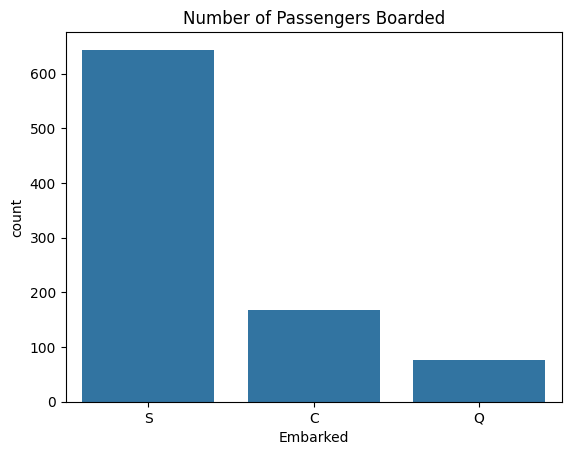

In [384]:
sns.countplot(x='Embarked',data=df_train)
plt.title('Number of Passengers Boarded')
plt.show()

In [385]:
df_train['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

df_train.isnull().sum()

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FareSingle       0
dtype: int64

In [386]:
df_train.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)

#df_train.drop('Ticket', axis=1, inplace=True)
#df_test.drop('Ticket', axis=1, inplace=True)

df_train.columns

Index(['PassengerId', 'Perished', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'FareSingle'],
      dtype='object')

In [387]:
df_train.replace({'Sex': {'male': 1, 'female': 2}}, inplace=True)
df_test.replace({'Sex': {'male': 1, 'female': 2}}, inplace=True)
df_train
#df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FareSingle
0,1,1,3,1,22.000000,1,0,A/5 21171,7.2500,NaN,S,3.62500
1,2,0,1,2,38.000000,1,0,PC 17599,71.2833,C85,C,35.64165
2,3,0,3,2,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,7.92500
3,4,0,1,2,35.000000,1,0,113803,53.1000,C123,S,26.55000
4,5,1,3,1,35.000000,0,0,373450,8.0500,NaN,S,8.05000
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,1,27.000000,0,0,211536,13.0000,NaN,S,13.00000
887,888,0,1,2,19.000000,0,0,112053,30.0000,B42,S,30.00000
888,889,1,3,2,17.360874,1,2,W./C. 6607,23.4500,NaN,S,5.86250
889,890,0,1,1,26.000000,0,0,111369,30.0000,C148,C,30.00000


In [388]:
embarked = pd.concat([df_train['Embarked'], df_test['Embarked']])
embarked
embarked_ohe = pd.get_dummies(embarked)
embarked_ohe
embarked_ohe_train = embarked_ohe[:891]
embarked_ohe_train
embarked_ohe_test = embarked_ohe[891:]
embarked_ohe_test
df_train = pd.concat([df_train, embarked_ohe_train], axis=1)
df_test = pd.concat([df_test, embarked_ohe_test], axis=1)

df_train.drop('Embarked', axis=1, inplace=True)
df_test.drop('Embarked', axis=1, inplace=True)

df_train.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,FareSingle,C,Q,S
0,1,1,3,1,22.0,1,0,A/5 21171,7.2500,NaN,3.62500,False,False,True
1,2,0,1,2,38.0,1,0,PC 17599,71.2833,C85,35.64165,True,False,False
2,3,0,3,2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,7.92500,False,False,True
3,4,0,1,2,35.0,1,0,113803,53.1000,C123,26.55000,False,False,True
4,5,1,3,1,35.0,0,0,373450,8.0500,NaN,8.05000,False,False,True


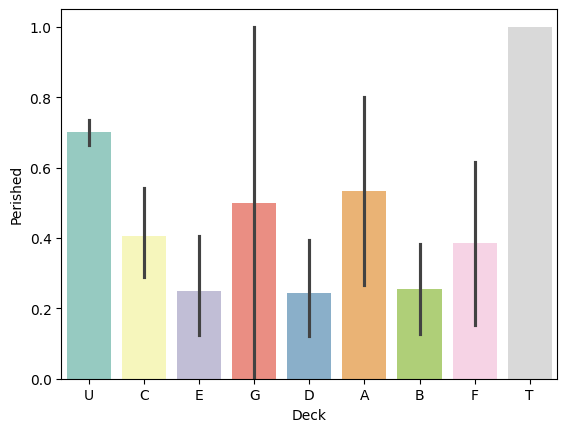

In [389]:
# 客室階層による生存率比較
df_train['Cabin'] = df_train['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
df_train['Deck'] = df_train['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得
sns.barplot(x="Deck", y="Perished", data=df_train, palette='Set3')

df_test['Cabin'] = df_test['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
df_test['Deck'] = df_test['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得

In [390]:
deck= pd.concat([df_train['Deck'], df_test['Deck']])
deck
deck_ohe = pd.get_dummies(deck)
deck_ohe
deck_ohe_train = deck_ohe[:891]
deck_ohe_train
deck_ohe_test = deck_ohe[891:]
deck_ohe_test
df_train = pd.concat([df_train, deck_ohe_train], axis=1)
df_test = pd.concat([df_test, deck_ohe_test], axis=1)
df_train

df_train.drop('Deck',  axis=1, inplace=True)
df_test.drop('Deck',  axis=1, inplace=True)

df_train.drop('Cabin',  axis=1, inplace=True)
df_test.drop('Cabin',  axis=1, inplace=True)

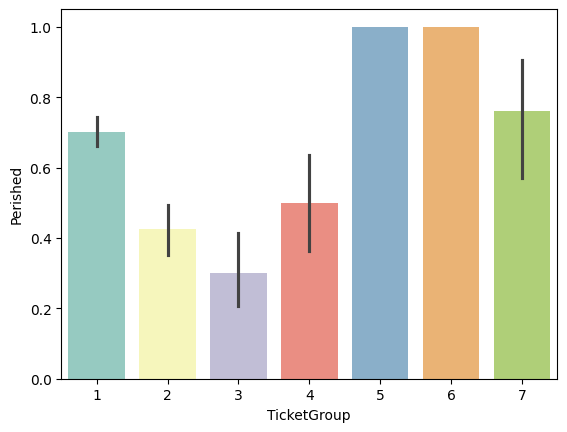

In [391]:
# チケットの文字数による生存率比較
Ticket_Count = dict(df_train['Ticket'].value_counts()) # チケットの文字数でグループ分け
df_train['TicketGroup'] = df_train['Ticket'].apply(lambda x:Ticket_Count[x]) # グループの振り分け
sns.barplot(x='TicketGroup', y='Perished', data=df_train, palette='Set3')

Ticket_Count = dict(df_test['Ticket'].value_counts()) # チケットの文字数でグループ分け
df_test['TicketGroup'] = df_test['Ticket'].apply(lambda x:Ticket_Count[x]) # グループの振り分け

In [392]:
df_train

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,FareSingle,...,A,B,C,D,E,F,G,T,U,TicketGroup
0,1,1,3,1,22.000000,1,0,A/5 21171,7.2500,3.62500,...,False,False,False,False,False,False,False,False,True,1
1,2,0,1,2,38.000000,1,0,PC 17599,71.2833,35.64165,...,False,False,True,False,False,False,False,False,False,1
2,3,0,3,2,26.000000,0,0,STON/O2. 3101282,7.9250,7.92500,...,False,False,False,False,False,False,False,False,True,1
3,4,0,1,2,35.000000,1,0,113803,53.1000,26.55000,...,False,False,True,False,False,False,False,False,False,2
4,5,1,3,1,35.000000,0,0,373450,8.0500,8.05000,...,False,False,False,False,False,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1,2,1,27.000000,0,0,211536,13.0000,13.00000,...,False,False,False,False,False,False,False,False,True,1
887,888,0,1,2,19.000000,0,0,112053,30.0000,30.00000,...,False,True,False,False,False,False,False,False,False,1
888,889,1,3,2,17.360874,1,2,W./C. 6607,23.4500,5.86250,...,False,False,False,False,False,False,False,False,True,2
889,890,0,1,1,26.000000,0,0,111369,30.0000,30.00000,...,False,False,True,False,False,False,False,False,False,1


In [393]:
df_train['TicketGroup2'] = 2
df_train.loc[(df_train['TicketGroup'].values== 2) | (df_train['TicketGroup'].values== 3) | (df_train['TicketGroup'].values == 4) , "TicketGroup2"] = 1
df_train

df_test['TicketGroup2'] = 2
df_test.loc[(df_test['TicketGroup'].values== 2) | (df_test['TicketGroup'].values== 3) | (df_test['TicketGroup'].values == 4) , "TicketGroup2"] = 1

df_train.drop('Ticket',  axis=1, inplace=True)
df_test.drop('Ticket',  axis=1, inplace=True)

df_train.drop('TicketGroup',  axis=1, inplace=True)
df_test.drop('TicketGroup',  axis=1, inplace=True)

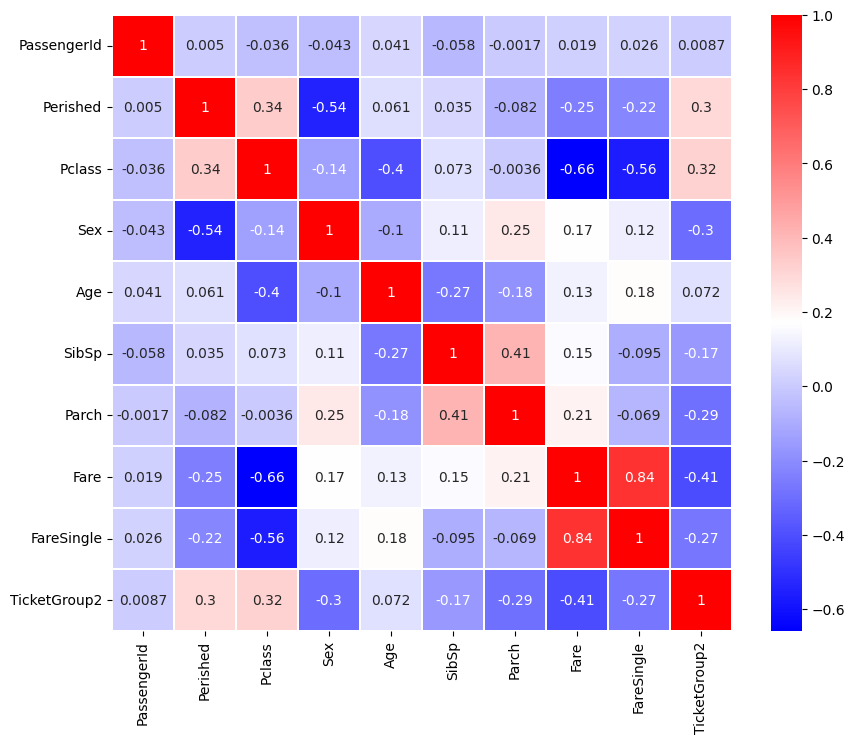

In [394]:
df_numeric = df_train.select_dtypes(include=['number'])
sns.heatmap(df_numeric.corr(),annot=True,cmap='bwr',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [395]:
#pclass = pd.concat([df_train['Pclass'], df_test['Pclass']])
#pclass
#pclass_ohe = pd.get_dummies(pclass)
#pclass_ohe
#pclass_ohe_train = pclass_ohe[:891]
#pclass_ohe_train
#pclass_ohe_test = pclass_ohe[891:]
#pclass_ohe_test

#df_train = pd.concat([df_train, pclass_ohe_train], axis=1)
#df_test = pd.concat([df_test, pclass_ohe_test], axis=1)

#df_train.drop('Pclass', axis=1, inplace=True)
#df_test.drop('Pclass', axis=1, inplace=True)

df_train.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Fare,FareSingle,C,...,A,B,C,D,E,F,G,T,U,TicketGroup2
0,1,1,3,1,22.0,1,0,7.2500,3.62500,False,...,False,False,False,False,False,False,False,False,True,2
1,2,0,1,2,38.0,1,0,71.2833,35.64165,True,...,False,False,True,False,False,False,False,False,False,2
2,3,0,3,2,26.0,0,0,7.9250,7.92500,False,...,False,False,False,False,False,False,False,False,True,2
3,4,0,1,2,35.0,1,0,53.1000,26.55000,False,...,False,False,True,False,False,False,False,False,False,1
4,5,1,3,1,35.0,0,0,8.0500,8.05000,False,...,False,False,False,False,False,False,False,False,True,2


In [396]:
#df_train.drop('Fare', axis=1, inplace=True)
#df_test.drop('Fare', axis=1, inplace=True)
df_train.drop('FareSingle', axis=1, inplace=True)
df_test.drop('FareSingle', axis=1, inplace=True)

##2. ベースラインモデルの構築

In [397]:
X = df_train.iloc[:, 2:].values
y = df_train.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values
df_test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
C               0
Q               0
S               0
A               0
B               0
C               0
D               0
E               0
F               0
G               0
T               0
U               0
TicketGroup2    0
dtype: int64

In [398]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# 標準化
sc = StandardScaler()
sc.fit(X_train)
sc.fit(X_test)
sc.fit(X_valid)
sc.fit(X)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_valid_std = sc.transform(X_valid)
X_std = sc.transform(X)



LightGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 392, number of negative: 231
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

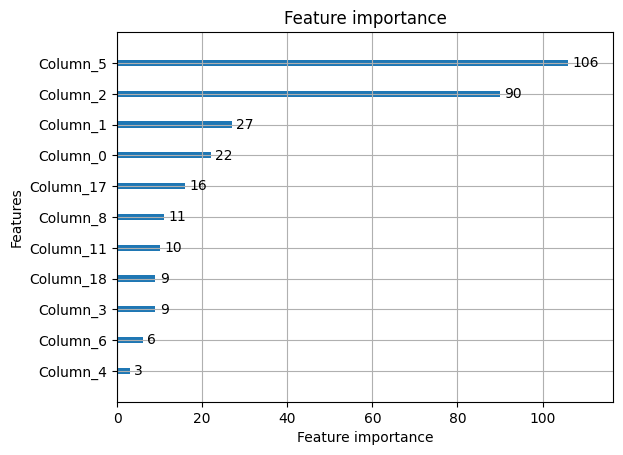

In [399]:
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

eval_set = [(X_valid_std, y_valid)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
lgbmc.fit(X_train_std, y_train, eval_set=eval_set, callbacks=callbacks)

#from sklearn import metrics
#y_pred = lgbmc.predict_proba(X_test)
#metrics.log_loss(y_valid, y_pred)

lgb.plot_importance(lgbmc)

import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# Accuracy score: 正解率。1のものは1として分類(予測)し、0のものは0として分類した割合
# Precision score: 精度。1に分類したものが実際に1だった割合
# Recall score: 検出率。1のものを1として分類(予測)した割合
# F1 score: PrecisionとRecallとの調和平均であり、0~1のスコア。数字が大きいほど良い評価。

preds = np.round(lgbmc.predict(X_valid_std))
print('Accuracy score = \t {}'.format(accuracy_score(y_valid, preds)))
print('Precision score = \t {}'.format(precision_score(y_valid, preds)))
print('Recall score =   \t {}'.format(recall_score(y_valid, preds)))
print('F1 score =      \t {}'.format(f1_score(y_valid, preds)))


Random Forest
*   max_depth：決定木の深さの最大値
*   min_samples_leaf：葉が含むサンプル数の最小値
*   n_estimators：決定木の数
*   n_jobs：計算に用いるスレッド数
*   random_state：乱数生成のシード値



In [400]:
#rfc = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc = RandomForestClassifier(max_depth=20, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)

#rfc.fit(X_train, y_train)
rfc.fit(X_train_std, y_train)


RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

In [401]:
print('Train Score: {}'.format(round(rfc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(rfc.score(X_valid, y_valid), 3)))

Train Score: 0.628
 Test Score: 0.571


In [402]:
param_grid = {'max_depth': [3, 5, 7, 11,13,17,19], #add 11
              'min_samples_leaf': [1, 2, 4, 8, 16, 32]} # add 8

for max_depth in param_grid['max_depth']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
        rfc_grid = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                            n_estimators=100, n_jobs=-1, random_state=42)
        #rfc_grid.fit(X_train, y_train)
        rfc_grid.fit(X_train_std, y_train)

        print('max_depth: {}, min_samples_leaf: {}'.format(max_depth, min_samples_leaf))
        #print('    Train Score: {}, Test Score: {}'.format(round(rfc_grid.score(X_train, y_train), 3),
        #                                                   round(rfc_grid.score(X_valid, y_valid), 3)))
        print('    Train Score: {}, Test Score: {}'.format(round(rfc_grid.score(X_train_std, y_train), 3),
                                                           round(rfc_grid.score(X_valid_std, y_valid), 3)))

max_depth: 3, min_samples_leaf: 1
    Train Score: 0.825, Test Score: 0.787
max_depth: 3, min_samples_leaf: 2
    Train Score: 0.823, Test Score: 0.791
max_depth: 3, min_samples_leaf: 4
    Train Score: 0.823, Test Score: 0.784
max_depth: 3, min_samples_leaf: 8
    Train Score: 0.82, Test Score: 0.776
max_depth: 3, min_samples_leaf: 16
    Train Score: 0.811, Test Score: 0.784
max_depth: 3, min_samples_leaf: 32
    Train Score: 0.803, Test Score: 0.78
max_depth: 5, min_samples_leaf: 1
    Train Score: 0.873, Test Score: 0.813
max_depth: 5, min_samples_leaf: 2
    Train Score: 0.864, Test Score: 0.81
max_depth: 5, min_samples_leaf: 4
    Train Score: 0.86, Test Score: 0.81
max_depth: 5, min_samples_leaf: 8
    Train Score: 0.848, Test Score: 0.799
max_depth: 5, min_samples_leaf: 16
    Train Score: 0.833, Test Score: 0.802
max_depth: 5, min_samples_leaf: 32
    Train Score: 0.812, Test Score: 0.784
max_depth: 7, min_samples_leaf: 1
    Train Score: 0.912, Test Score: 0.802
max_depth: 7,

GradientBoostingClassifier

In [403]:
#gbc = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=1)
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=7, random_state=1)
gbc.fit(X_train_std, y_train)

print('Train Score: {}'.format(round(gbc.score(X_train_std, y_train), 3)))
print(' Test Score: {}'.format(round(gbc.score(X_valid_std, y_valid), 3)))

# Make predictions
#predictions = gbc.predict(X_test)

Train Score: 0.982
 Test Score: 0.791


# Cross Validation

Random Forest

In [404]:
rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
#rfc_gs.fit(X, y)
rfc_gs.fit(X_std, y)

print('Best Parameters: {}'.format(rfc_gs.best_params_))
print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1}
CV Score: 0.826


GradientBoostingClassifier

In [405]:
gbc_gs = GridSearchCV(GradientBoostingClassifier(n_estimators=100, random_state=42), param_grid, cv=5)
#gbc_gs.fit(X, y)
gbc_gs.fit(X_std, y)

print('Best Parameters: {}'.format(gbc_gs.best_params_))
print('CV Score: {}'.format(round(gbc_gs.best_score_, 3)))

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 16}
CV Score: 0.843


LightGBM

In [406]:
#lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)
lgbmc_gs = GridSearchCV(lgb.LGBMClassifier(boosting_type='goss',random_state=42), param_grid, cv=5)
#gbc_gs.fit(X, y)
lgbmc_gs.fit(X_std, y)

print('Best Parameters: {}'.format(lgbmc_gs.best_params_))
print('CV Score: {}'.format(round(lgbmc_gs.best_score_, 3)))

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

#3. 特徴量エンジニアリング

In [407]:
df_fe_train = df_train.copy()
df_fe_test = df_test.copy()

#df_fe_train['Family'] = df_train['SibSp'] + df_train['Parch']
#df_fe_test['Family'] = df_test['SibSp'] + df_test['Parch']

#df_train.drop('SibSp', axis=1, inplace=True)
#df_test.drop('SibSp', axis=1, inplace=True)

#df_train.drop('Parch', axis=1, inplace=True)
#df_test.drop('Parch', axis=1, inplace=True)

df_fe_train.head(10)

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,...,A,B,C,D,E,F,G,T,U,TicketGroup2
0,1,1,3,1,22.000000,1,0,7.2500,False,False,...,False,False,False,False,False,False,False,False,True,2
1,2,0,1,2,38.000000,1,0,71.2833,True,False,...,False,False,True,False,False,False,False,False,False,2
2,3,0,3,2,26.000000,0,0,7.9250,False,False,...,False,False,False,False,False,False,False,False,True,2
3,4,0,1,2,35.000000,1,0,53.1000,False,False,...,False,False,True,False,False,False,False,False,False,1
4,5,1,3,1,35.000000,0,0,8.0500,False,False,...,False,False,False,False,False,False,False,False,True,2
5,6,1,3,1,25.962264,0,0,8.4583,False,True,...,False,False,False,False,False,False,False,False,True,2
6,7,1,1,1,54.000000,0,0,51.8625,False,False,...,False,False,False,False,True,False,False,False,False,2
7,8,1,3,1,2.000000,3,1,21.0750,False,False,...,False,False,False,False,False,False,False,False,True,1
8,9,0,3,2,27.000000,0,2,11.1333,False,False,...,False,False,False,False,False,False,False,False,True,1
9,10,0,2,2,14.000000,1,0,30.0708,True,False,...,False,False,False,False,False,False,False,False,True,1


#4. 様々なモデルの構築・調整

Random Forest

In [408]:
rfc = RandomForestClassifier(max_depth=17, min_samples_leaf=2, n_estimators=300, n_jobs=-1, random_state=42)
rfc.fit(X_train_std, y_train)

#print('Train Score: {}'.format(round(rfc_fe_train.score(X_fe_train, y_fe_train), 3)))
#print(' Test Score: {}'.format(round(rfc_fe_train.score(X_fe_valid, y_fe_valid), 3)))

print('Train Score: {}'.format(round(rfc.score(X_train_std, y_train), 3)))
print(' Test Score: {}'.format(round(rfc.score(X_valid_std, y_valid), 3)))

Train Score: 0.917
 Test Score: 0.795


Logistic Regression

In [409]:
lr = LogisticRegression(random_state=42)
#lr.fit(X_train, y_train)
lr.fit(X_train_std, y_train)

print('Logistic Regression \n')
#print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
#print(' Test Score: {}'.format(round(lr.score(X_valid, y_valid), 3)))

print('Train Score: {}'.format(round(lr.score(X_train_std, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_valid_std, y_valid), 3)))


Logistic Regression 

Train Score: 0.815
 Test Score: 0.799


多層パーセプトロンモデル

In [410]:
mlpc = MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=0)
#mlpc.fit(X_train, y_train)
mlpc.fit(X_train_std, y_train)

print('Multilayer Perceptron \n')
#print('Train Score: {}'.format(round(mlpc.score(X_train, y_train), 3)))
#print(' Test Score: {}'.format(round(mlpc.score(X_valid, y_valid), 3)))

print('Train Score: {}'.format(round(mlpc.score(X_train_std, y_train), 3)))
print(' Test Score: {}'.format(round(mlpc.score(X_valid_std, y_valid), 3)))



Multilayer Perceptron 

Train Score: 0.913
 Test Score: 0.795


GradientBoostingClassifier

In [411]:
#gbc = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=1)
gbc = GradientBoostingClassifier(n_estimators=100, max_depth=17, min_samples_leaf=32, random_state=1)

gbc.fit(X_train_std, y_train)

print('Train Score: {}'.format(round(gbc.score(X_train_std, y_train), 3)))
print(' Test Score: {}'.format(round(gbc.score(X_valid_std, y_valid), 3)))

# Make predictions
#predictions = gbc.predict(X_test)

Train Score: 0.926
 Test Score: 0.799


LightGBM

In [412]:
lgbmc = GridSearchCV(lgb.LGBMClassifier(boosting_type='goss',max_depth=5, min_samples_leaf=8,random_state=42), param_grid, cv=5)
#gbc_gs.fit(X, y)
lgbmc.fit(X_train_std, y_train)
print('Train Score: {}'.format(round(gbc.score(X_train_std, y_train), 3)))
print(' Test Score: {}'.format(round(gbc.score(X_valid_std, y_valid), 3)))

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

#5. モデルのアンサンブリング

In [413]:
#rfc_pred = rfc.predict_proba(X_test)
#lr_pred = lr.predict_proba(X_test)
#mlpc_pred = mlpc.predict_proba(X_test)

rfc_pred = rfc.predict_proba(X_test_std)
lr_pred = lr.predict_proba(X_test_std)
mlpc_pred = mlpc.predict_proba(X_test_std)
gbc_pred = gbc.predict_proba(X_test_std)
lgb_pred = lgbmc.predict_proba(X_test_std)

#pred_proba = (rfc_pred + lr_pred + mlpc_pred + gbc_pred) / 4
#pred_proba = (rfc_pred + gbc_pred + lgb_pred) / 3
pred_proba = (rfc_pred + lr_pred + mlpc_pred + gbc_pred + lgb_pred) / 5

#pred_proba
pred = pred_proba.argmax(axis=1)
#mlpc_pred
#pred = rfc_pred

pred_kaggle = np.array(pred)

#for k np.range(pred.size):
for k in range(0,len(pred_kaggle)):
  if pred_kaggle[k] == 1:
    pred_kaggle[k] = 0
  else :
    pred_kaggle[k] = 1

pred_kaggle

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=16. Current value: min_data_in_leaf=16
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#6. 予測の出力・提出

In [414]:
 # 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
#path = '/content/drive/My Drive/Colab Notebooks/GCI_2024_Summer/Competitions/competition_1/'
path = "/content/drive/MyDrive/data/"
submission = pd.read_csv(path + 'gender_submission.csv')
submission

submission_kaggle = pd.read_csv(path + 'gender_submission.csv')
submission_kaggle

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [415]:
pred.shape

(418,)

In [416]:
submission['Perished'] = pred
submission

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [417]:
submission_kaggle['Survived'] = pred_kaggle
submission_kaggle.drop('Perished', axis=1, inplace=True)
submission_kaggle

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [418]:
# JupyterLabなどローカルで作業する場合
# パスは必要に応じて変更の必要あり
#submission.to_csv('/content/drive/My Drive/Colab Notebooks/GCI_2024_Summer/Competitions/competition_1/submission.csv', index=False)
submission.to_csv('/content/drive/MyDrive/data/submission.csv', index=False)
submission_kaggle.to_csv('/content/drive/MyDrive/data/submission_kaggle.csv', index=False)

In [419]:
# Google Drive・Google Colaboratoryで作業する場合
submission.to_csv('submission.csv',index=False)
submission_kaggle.to_csv('submission_kaggle.csv',index=False)

from google.colab import files
files.download('submission.csv')
files.download('submission_kaggle.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>